<a href="https://colab.research.google.com/github/lamantinushka/StructuredCovariance/blob/master/UQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SWAG for Uncertainty Quantification

In [0]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda')

We define our model to be Bayesian from the beggining, do tha after SWAG training it was able to work both in MAP and Baeyesian modes

In [0]:
class MNISTBnn(nn.Module):
  
    def __init__(self, hidden_size = 400, max_rank = 8):
        super(MNISTBnn, self).__init__()
        inp_dim = 784
        self.max_rank = max_rank
        self.out_dim = 10
        self.shapes = [(inp_dim + 1, hidden_size), 
                       (hidden_size + 1, hidden_size),
                       (hidden_size + 1, self.out_dim)]
        self.sizes = [sh[0]*sh[1] for sh in self.shapes]
        
        self.W1 = torch.randn(*self.shapes[0])
        self.W2 = torch.randn(*self.shapes[1])
        self.W3 = torch.randn(*self.shapes[2])
        
        size = sum(self.sizes)
        
        self.mu = torch.nn.Parameter(torch.randn(size))
        self.U = torch.nn.Parameter(torch.randn(size, max_rank))
        self.d = torch.nn.Parameter(torch.ones(size))
        self.w = None
        self.frozen = False
        
    def _freeze(self):
        self.frozen = True
        
    def _defrost(self):
        self.frozen = False
        
    def forward(self, x, sample = False):
        if sample:
            self.sample()
            z = torch.cat([x, torch.ones(x.shape[0], 1, device = x.device, dtype = torch.float)], 
                      dim = -1) @ self.W1
            z = torch.cat([torch.relu(z), torch.ones(z.shape[0], 1, device = x.device, dtype = torch.float)], 
                      dim = -1) @ self.W2
            logits = torch.cat([torch.relu(z), torch.ones(z.shape[0], 1, device = x.device, dtype = torch.float)], 
                           dim = -1) @ self.W3
            return logits

        W1 = self.mu[:self.sizes[0]].view(*self.shapes[0])
        W2 = self.mu[self.sizes[0]:-self.sizes[2]].view(*self.shapes[1])
        W3 = self.mu[-self.sizes[2]:].view(*self.shapes[2])
        
        z = torch.cat([x, torch.ones(x.shape[0], 1, device = x.device, dtype = torch.float)], 
                      dim = -1) @ W1
        z = torch.cat([torch.relu(z), torch.ones(z.shape[0], 1, device = x.device, dtype = torch.float)], 
                      dim = -1) @ W2
        logits = torch.cat([torch.relu(z), torch.ones(z.shape[0], 1, device = x.device, dtype = torch.float)], 
                           dim = -1) @ W3
        return logits
         
      
    def sample(self):
        if self.frozen:
            pass
        else:
            k = 1/(math.sqrt(2*(self.max_rank - 1)))
            non_diag = k*self.U @ torch.randn(self.max_rank, device = device)
            diag = (1/math.sqrt(2))*torch.sqrt(self.d) * torch.randn_like(self.d, device = device)
            w = self.mu + diag + non_diag
            self.W1 = w[:self.sizes[0]].view(*self.shapes[0])
            self.W2 = w[self.sizes[0]:-self.sizes[2]].view(*self.shapes[1])
            self.W3 = w[-self.sizes[2]:].view(*self.shapes[2])
          
    def nll_loss(self, x, y, n_samples = 4):
        """ 
        x - tensor [batch_size x feature_size]
        y - one-hot-encoded tensor [batch_size x n_classes]
        """
        preds = torch.zeros(n_samples, x.shape[0], self.out_dim).to(device)
        criterion = nn.NLLLoss()
        for i in range(n_samples):
            w = self.sample()
            logits = self(x, sample = True)
            preds[i] = logits.log_softmax(-1)
        log_probs = preds.mean(0) 
        nll = criterion(log_probs, y.to(device))
        return nll

Pre-training procedure:

In [0]:
def sample_batch(X, y, batch_size):
    idxes = np.random.choice(len(y), size = batch_size, replace=False) 
    return X[idxes], y[idxes]

def train_simple_mnist(model, X, y, params):
    loss = []
    batch_size = params["batch_size"]
    n_batches = (X.shape[0] + batch_size - 1)//batch_size 
    optimizer = torch.optim.Adam(model.parameters(), lr = params["lr"])
    criterion = nn.CrossEntropyLoss()
    for epoch in range(params["n_epoch"]):
        idxes = np.arange(X.shape[0])
        np.random.shuffle(idxes)
        for i in range(n_batches):
            idx_batch = idxes[i*batch_size: (1+i)*batch_size]
            x_batch, y_batch = X[idx_batch], y[idx_batch]
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(x_batch, sample = False)
            nll = criterion(logits, y_batch)
            nll.backward()
            optimizer.step()
            loss.append(nll.item())
        
    return loss

SWAG training code. We start from pre-trained model, then run SGD for sufficiently long time to approximate moments, and finally use last L $\theta_i - \bar\theta$ vectors to approximate nondiagonal component of $\Sigma$

In [0]:
def run_swag_mnist(model, X, y, params):
    loss = []
    first_moment = model.mu
    second_moment = model.mu**2
    U = torch.zeros(model.mu.shape[0], model.max_rank)
    optimizer = torch.optim.SGD(model.parameters(), lr = params["lr_swag"])
    criterion = nn.CrossEntropyLoss()
    N = 1
    C = params["C"]
    for i in range(1, C*params["n_steps_swag"] + 1):
        x_batch, y_batch = sample_batch(X, y, params["batch_size"])
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        logits = model(x_batch, sample = False)
        nll = criterion(logits, y_batch)
        nll.backward()
        optimizer.step()
        if i % C == 0:
            first_moment = (first_moment*N + model.mu)/(N+1)
            second_moment = (second_moment*N + model.mu**2)/(N+1)
            N += 1
            loss.append(nll.item())
    U = torch.zeros_like(model.U, device = device)
    for i in range(1, C*model.max_rank + 1):
        x_batch, y_batch = sample_batch(X, y, params["batch_size"])
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        logits = model(x_batch, sample = False)
        nll = criterion(logits, y_batch)
        nll.backward()
        optimizer.step()
        if i % C == 0:
            first_moment = (first_moment*N + model.mu)/(N+1)
            second_moment = (second_moment*N + model.mu**2)/(N+1)
            U[:, i//C - 1] = model.mu - first_moment
            N += 1
            loss.append(nll.item())
    d = second_moment - first_moment**2
    return first_moment, U, d, loss

Loading data:

In [0]:
X_train, Y_train = torch.load('data/MNIST/processed/training.pt')
X_test, Y_test = torch.load('data/MNIST/processed/test.pt')


X_train = X_train.view(-1, 784)
X_test = X_test.view(-1, 784)
X_train = (X_train - X_train.float().mean()) / X_train.float().std()
X_test = (X_test - X_test.float().mean()) / X_test.float().std()

Y_train_ohe = torch.zeros(len(X_train), 10)
Y_train_ohe[np.arange(len(Y_train)), Y_train] = 1
Y_test_ohe = torch.zeros(len(X_test), 10)
Y_test_ohe[np.arange(len(Y_test)), Y_test] = 1

N = X_train.shape[0]

In [0]:
params = {"task": "australian",
          "batch_size": 128,
          "n_epoch": 100,
          "lr": 1e-5,
          "rank": 20,
          "C": 100,
          "n_steps_swag": 1000,
          "lr_swag": 3*1e-9
         }

Training (or loading pretrained model)

In [0]:
model = MNISTBnn().to(device)
#model.load_state_dict(torch.load('mnist_model'))

#loss = train_simple_mnist(model, X_train, Y_train, params)
#torch.save(model.state_dict(), 'mnist_model')
#plt.plot(loss)

Function to compute NLL on test set

In [0]:
def compute_nll(model, X, y, swag = False):
    S = 0.
    L = 0.
    criterion = nn.CrossEntropyLoss()
    for i in range(X.shape[0]//100):
        x_batch = X[i*100: (i+1)*100].to(device)
        y_batch = y[i*100: (i+1)*100].to(device)
        l = x_batch.shape[0]
        if swag:
            S += model.nll_loss(x_batch, y_batch, n_samples = 20)*l
        else:
            logits = model(x_batch)
            S += criterion(logits, y_batch)*l
        L += l
    return S/L  

In [0]:
compute_nll(model, X_test, Y_test)

tensor(22.6494, device='cuda:0', grad_fn=<DivBackward0>)

Run SWAG procedure. We clamp d as it should be positive semidefinite, and due to stochasticity it can has small negative values that are crucial for the sampling procedure

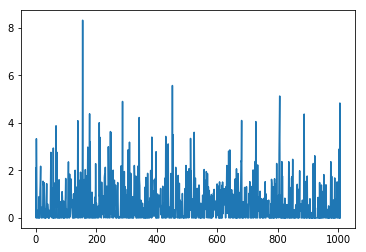

In [0]:
mu, U, d, loss = run_swag_mnist(model, X_train, Y_train, params)
model.mu = nn.Parameter(mu)
model.U = nn.Parameter(U)
model.d = nn.Parameter(d.clamp_min(0))

plt.plot(loss)

In [0]:
#torch.save(model.state_dict(), 'mnist_model_swag')
model.load_state_dict(torch.load('mnist_model_swag'))

And compute NLL again:

In [0]:
compute_nll(model, X_test, Y_test, swag = True)

tensor(24.7715, device='cuda:0', grad_fn=<DivBackward0>)

We can see that NLL did not improve in this case, but let's look at the uncertainty

In [0]:
def compute_uncertainty(model, X, n_samples):
    preds = torch.zeros(n_samples, X.shape[0], 10)
    for i in range(n_samples):
        logits = model(X, sample = True).softmax(-1)
        preds[i] = logits.cpu()
    return preds.std(0).sum(-1)

We use 4 different sets of points to estimate mean uncertainty.
- True 2000 points from test data
- Sum of pairs of different points from test set
- Random noice with aplitude 2.5
- Samples restored from the grid in the latent space by VAE

True points:

In [0]:
X0 = X_test[:2000].to(device)
unc0 = compute_uncertainty(model, X0, 200)
unc0.mean()

tensor(0.1852, grad_fn=<MeanBackward0>)

Sum of points:

In [0]:
X1 = X_test[:1000].to(device) + X_test[1000:2000].to(device)
unc1 = compute_uncertainty(model, X1, 200)
unc1.mean()

tensor(0.7688, grad_fn=<MeanBackward0>)

Random noise:

In [0]:
X2 = 5*(torch.rand(1000, 784) - 1).to(device)
unc2 = compute_uncertainty(model, X2, 200)
unc2.mean()

tensor(0.4633, grad_fn=<MeanBackward0>)

Here we train simple VAE model to generate samples for Uncertainty Quantification

VAE code is taken from https://github.com/pytorch/examples/blob/master/vae/main.py

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 50)
        self.fc31 = nn.Linear(50, 2)
        self.fc32 = nn.Linear(50, 2)
        self.fc3 = nn.Linear(2, 50)
        self.fc5 = nn.Linear(50, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc21(torch.relu(self.fc1(x))))
        return self.fc31(h1), self.fc32(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc5(torch.relu(self.fc3(z))))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
def train_load(X, Y):
    batch_size = 128
    n_batches =X.shape[0]//batch_size
    idxes = np.arange(X.shape[0])
    np.random.shuffle(idxes)
    for i in range(n_batches):
        idx_batch = idxes[i*batch_size: (1+i)*batch_size]
        x_batch, y_batch = X[idx_batch], Y[idx_batch]
        yield x_batch.to(device), y_batch.to(device)
        
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    vae.train()
    train_loss = 0
    train_loader = train_load(X_train, Y_train)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), 60000,
                100. * batch_idx / 468,
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / 60000))
    
for epoch in range(1, 21):
    train(epoch)

In [0]:
torch.save(vae.state_dict(), 'simple_vae')

In [0]:
vae = VAE().to(device)
vae.load_state_dict(torch.load('simple_vae.dms'))

<All keys matched successfully>

Check if model restores data:

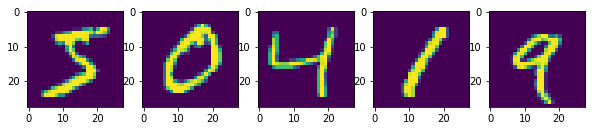

In [0]:
x = X_train[:5].to(device)
fig, axis = plt.subplots(ncols = 5, figsize = (10, 2))
for i in range(5):
    axis[i].imshow(x[i].cpu().detach().view(28, 28))

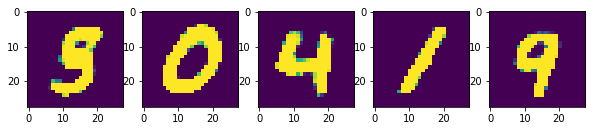

In [0]:
y = vae.decode(vae.encode(x)[0])
fig, axis = plt.subplots(ncols = 5, figsize = (10, 2))
for i in range(5):
    axis[i].imshow(y[i].cpu().detach().view(28, 28))

Let's look at the distribution in the latent space:

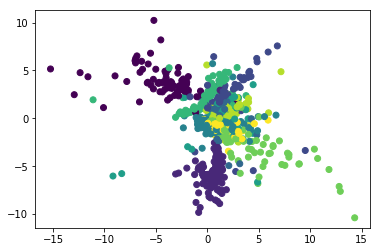

In [0]:
test = X_test[:1000].to(device)
labels = Y_test[:1000]
vecs = vae.encode(test)[0]
vecs = vecs.cpu().detach().numpy()
plt.scatter(vecs[:, 0], vecs[:, 1], c = labels.numpy())

Create and decode uniformal examples in latent space:

In [0]:
A = np.meshgrid(np.linspace(-20, 20, 35), np.linspace(-20, 20, 35))
z = torch.cat([torch.FloatTensor(A[0]).view(1, 35, 35), torch.FloatTensor(A[1]).view(1, 35, 35)], dim = 0).view(2, -1).t()

Compute uncertainty:

In [0]:
imgs = vae.decode(z.to(device))
unc3 = compute_uncertainty(model, imgs, 200)
unc3.mean()

tensor(0.3751, grad_fn=<MeanBackward0>)

And finally let's look at the uncertainty distribution in the latent space:

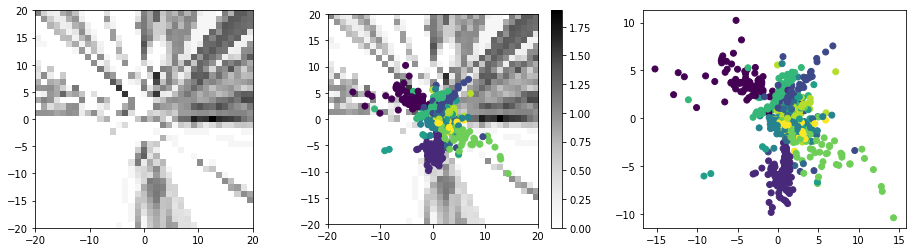

In [0]:
fig, axis = plt.subplots(ncols = 3, figsize = (16, 4))
im = axis[0].imshow(unc3.view(35, 35).cpu().detach(), extent=[-20,20,-20,20], cmap = 'Greys')
im = axis[1].imshow(unc3.view(35, 35).cpu().detach(), extent=[-20,20,-20,20], cmap = 'Greys')
axis[1].scatter(vecs[:, 0], vecs[:, 1], c = labels.numpy())
axis[2].scatter(vecs[:, 0], vecs[:, 1], c = labels.numpy())
fig.colorbar(im, ax = axis[1])